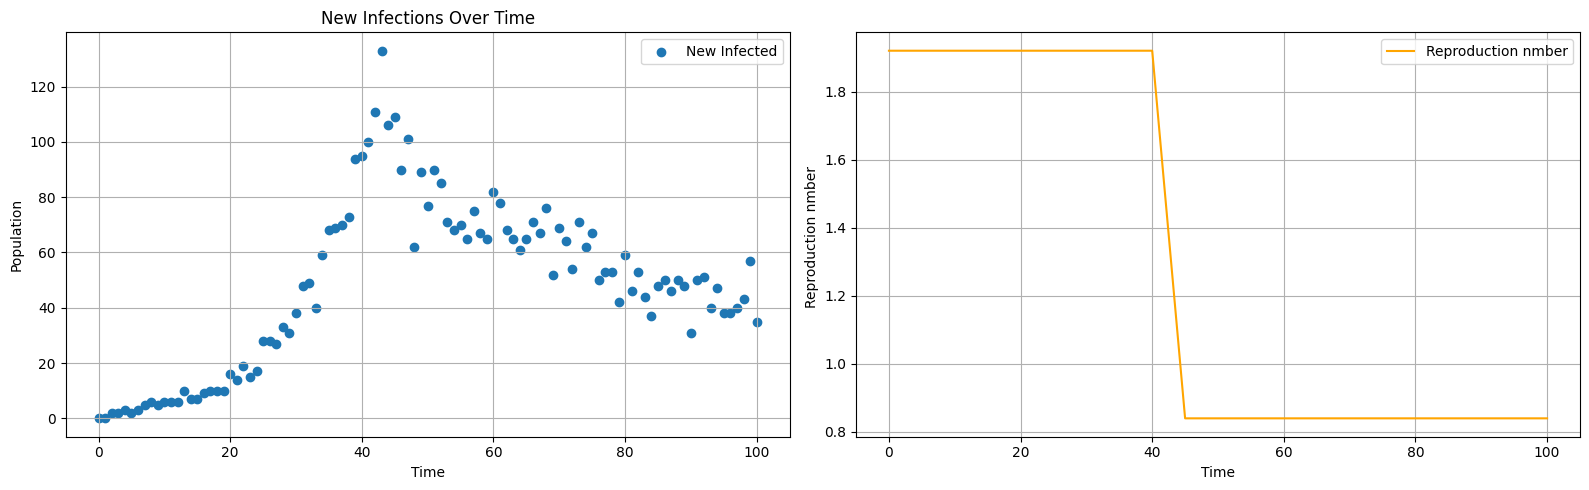

In [1]:
#####################################################################################
# Application of     BMA-SMC^2 for the Scenario A in the paper
# Note: All functions must be in the same folder.
#####################################################################################
# import the necessary libraies

# Standard Libraries
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import poisson, norm, nbinom
from numpy.random import binomial, normal, negative_binomial
from joblib import Parallel, delayed  # For parallel computing
from tqdm import tqdm
from scipy.stats import nbinom

# SMC2 Libraries
from models import stochastic_sir_model, dthp_model
from smc_squared import BMA_SMC2
from smc_visualization import trace_smc, plot_smc, compute_model_average
# Style Configuration


############  SEPTP 1:Import/create your dataset ###########################
#### Generate the simulated data with time varying beta ###############
#######################################################################


import numpy as np
import pandas as pd
from numpy.random import binomial

def piecewise_beta(t):
    if t <= 40:
        return 0.32
    elif t <= 45:
        return 0.32 - ((0.32 - 0.14) / (45 - 40)) * (t - 40)
    else:
        return 0.14

def sir_var_beta(y, theta, t, dt=1):
    # Unpack variables
    S, E, I, R, NI, _ = y  # _ used because B is recalculated
    N = S + E+ I + R

    # Unpack parameters
    sigma, gamma = theta

    # Compute current beta using piecewise rule
    B = piecewise_beta(t)

    # Transition probabilities
    P_SE = 1 - np.exp(-B * I / N * dt)     # S -> E
    P_EI = 1 - np.exp(-sigma * dt)         # E -> I
    P_IR = 1 - np.exp(-gamma * dt)         # I -> R

    # Sample transitions
    B_SE = binomial(S, P_SE)               # S -> E
    B_EI = binomial(E, P_EI)               # E -> I
    B_IR = binomial(I, P_IR)               # I -> R

    # Update compartments
    S -= B_SE
    E += B_SE - B_EI
    I += B_EI - B_IR
    R += B_IR
    NI = B_EI  # New infections (E -> I)

    # Return updated state with non-negative values
    y_next = [max(0, val) for val in [S, E, I, R, NI, B]]
    return y_next




# def solve_sir_var_beta(model, theta, InitialState, t_start, t_end, dt=1, overdispersion=0.02):
#     t_values = np.arange(t_start, t_end + dt, dt)
#     results = np.zeros((len(t_values), len(InitialState)))
#     results[0] = InitialState

#     for i in range(1, len(t_values)):
#         results[i] = model(results[i - 1], theta, i, dt)

#     results_df = pd.DataFrame(results, columns=['S', 'I', 'R', 'NI', 'B'])
#     results_df['time'] = t_values

#     # Ensure NI is strictly positive to avoid division errors
#     mean_NI = results_df['NI'].clip(lower=1e-6)

#     # Negative Binomial parameters
#     r = 1.0 / overdispersion  # shape
#     p = r / (r + mean_NI)     # success probability

#     # Draw samples from Negative Binomial for each time point
#     obs = nbinom.rvs(n=r, p=p)

#     results_df['obs'] = obs

#     return results_df

def solve_sir_var_beta(model, theta, InitialState, t_start, t_end, dt=1, overdispersion=0.01):
    t_values = np.arange(t_start, t_end + dt, dt)
    results = np.zeros((len(t_values), len(InitialState)))
    results[0] = InitialState

    for i in range(1, len(t_values)):
        results[i] = model(results[i - 1], theta, i, dt)

    results_df = pd.DataFrame(results, columns=['S', 'E', 'I', 'R', 'NI', 'B'])
    results_df['time'] = t_values

    # Sample observations from Negative Binomial
    mean_NI = results_df['NI'].clip(lower=1e-6)  # Avoid zero mean
    size = 1 / overdispersion  # shape parameter (r)
    p = size / (size + mean_NI)  # success probability

    # Sample from nbinom
    results_df['obs'] =  results_df['NI']

    return results_df

    

    

# Initial conditions
t = 0
B = 0.32
true_theta = [1/2, 1/6]  # sigma (latency rate), gamma (recovery rate)
N_pop = 50000
InitialState = [N_pop - 10, 0, 10, 0, 0, B]  # S, E, I, R, NI, B
t_start = 0
t_end = 100
dt = 1

np.random.seed(123) # Set a seed for reproducibility
simulated_data = solve_sir_var_beta(sir_var_beta, true_theta, InitialState, t_start, t_end, dt)
simulated_data['Rt'] =simulated_data['B']/(1/6) # reproduction number
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# First subplot: Plot new infections
axes[0].scatter(simulated_data['time'].index, simulated_data['obs'], label='New Infected')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('New Infections Over Time')

# Second subplot: Plot transmission rate
axes[1].plot(simulated_data['time'].index, simulated_data['Rt'], label='Reproduction nmber', color='orange')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Reproduction nmber ')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plots
plt.show()
simulated_data




#################################################################################################
############ SEPTP 2: Define your observation distribution ######################################
# The observation_dist.py contains some examples, you extend to incorporate multiple dataste
#################################################################################################

# Negative Binomial log-likelihood
def obs_dist_negative_binomial(observed_data, model_data, theta, theta_names):
    epsi = 1e-4
    model_est_case = np.maximum(epsi, model_data['NI'].to_numpy())
    param = dict(zip(theta_names, theta))
    overdispersion = param.get('phi', 0.1)  # Default value for 'phi' if not provided
    log_likelihoods = nbinom.logpmf(observed_data['obs'], 1 / overdispersion, 1 / (1 + overdispersion * model_est_case))
    log_likelihoods[np.isnan(log_likelihoods) | np.isinf(log_likelihoods)] = -np.inf
    return log_likelihoods

#################################################################################################
############ SEPTP 3: Run the SMC^2 #####################################################################
# You need to defined initial conditions for the state and prior for the parameter you want to estimate
##########################################################################################################

np.random.seed(123) # Set a seed for reproducibility

# # ##### # setting state and parameter

### SIR initial state and prior distribution
state_info_sir = {
    'S': {'prior': [N_pop-20, N_pop, 0, 0, 'uniform']},  # Susceptibles
    'E': {'prior': [0, 5, 0, 0, 'uniform']},  # Exposed
    'I': {'prior': [0, 15, 0, 0, 'uniform']},  # Infected
    'R': {'prior': [0, 0, 0, 0, 'uniform']},  # Removed (Recovered or Deceased)
    'NI': {'prior': [0, 0, 0, 0, 'uniform']},  # Newly Infected
    'B': {'prior': [0, np.inf, 0.32, 0.01, 'normal']},  # Transmission rate (Beta)
}

theta_info_sir = {
    'sigma': {'prior': [0.2, 0.7, 0.5, 0.05,'truncnorm','log']},  # Removal rate (Inverse of infectious period)
    'gamma': {'prior': [0, 1, 0.16, 0.05, 'truncnorm', 'log']},  # Removal rate (Inverse of infectious period)
    'nu_beta': {'prior': [0.05, 0.2, 0.1, 0.01, 'truncnorm', 'log']},  # Beta variability
    'phi': {'prior': [1e-5, 0.2, 0, 0, 'uniform', 'log']}  # Overdispersion parameter
}

# DTHP model state and parameter information
state_info_dthp = {
    'NI': {'prior': [0, 3, 0, 0, 'uniform']},  # Newly Infected
    # 'C_I': {'prior': [0, 0, 0, 0, 'uniform']},  # Cumulative Infected
    'Rt': {'prior': [0, np.inf, 1.8, 0.05, 'normal']}  # Reproduction Number
}

theta_info_dthp = {
    'omega_I': {'prior': [0, 1, 0.1, 0.05, 'truncnorm', 'log']},  # Decay parameter in the triggering kernel
    'nu_beta': {'prior': [0.05, 0.2, 0.1, 0.01, 'truncnorm', 'log']},  # Beta variability
    'phi': {'prior': [1e-5, 0.2, 0, 0, 'uniform', 'log']}  # Overdispersion parameter
}




fday=14
days=len(simulated_data)-fday

np.random.seed(123) # Set a seed for reproducibility
# smc2_results = BMA_SMC2(
#     model_sir=stochastic_sir_model,
#     model_dthp= dthp_model, 
#     initial_state_info_dthp=state_info_dthp , 
#     initial_theta_info_dthp=theta_info_dthp , 
#     initial_state_info_sir=state_info_sir , 
#     initial_theta_info_sir=theta_info_sir , 
#     observed_data=simulated_data[:days],
#     num_state_particles=200,
#     num_theta_particles=400,
#     observation_distribution=obs_dist_negative_binomial,
#     forecast_days=fday,
#     N=N_pop
# )







In [2]:
import pickle


# with open("Ens_SMC2_exp1.wpickle", "wb") as file:
#     pickle.dump(smc2_results, file)

# with open("Ens_SMC2_exp1.wpickle", "rb") as file:
#    smc2_results= pickle.load(file)

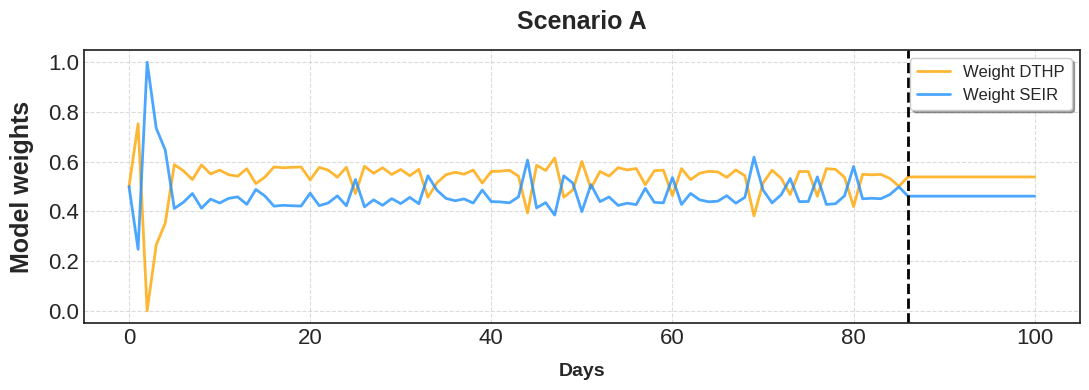

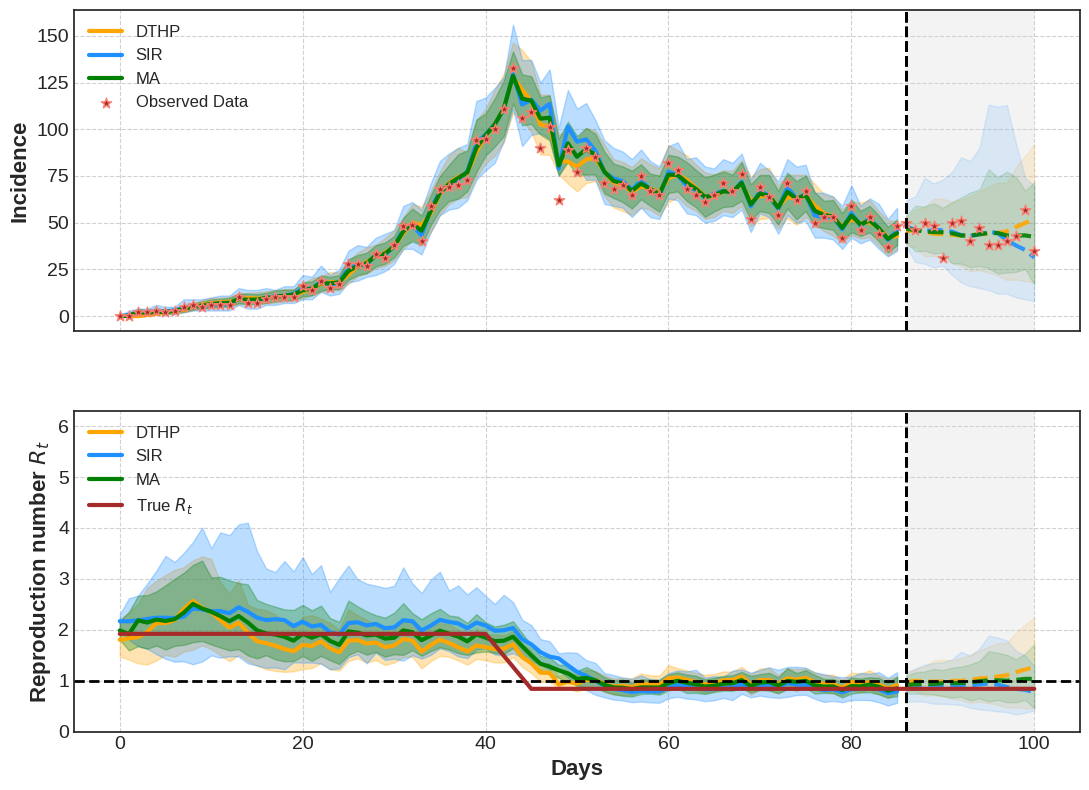

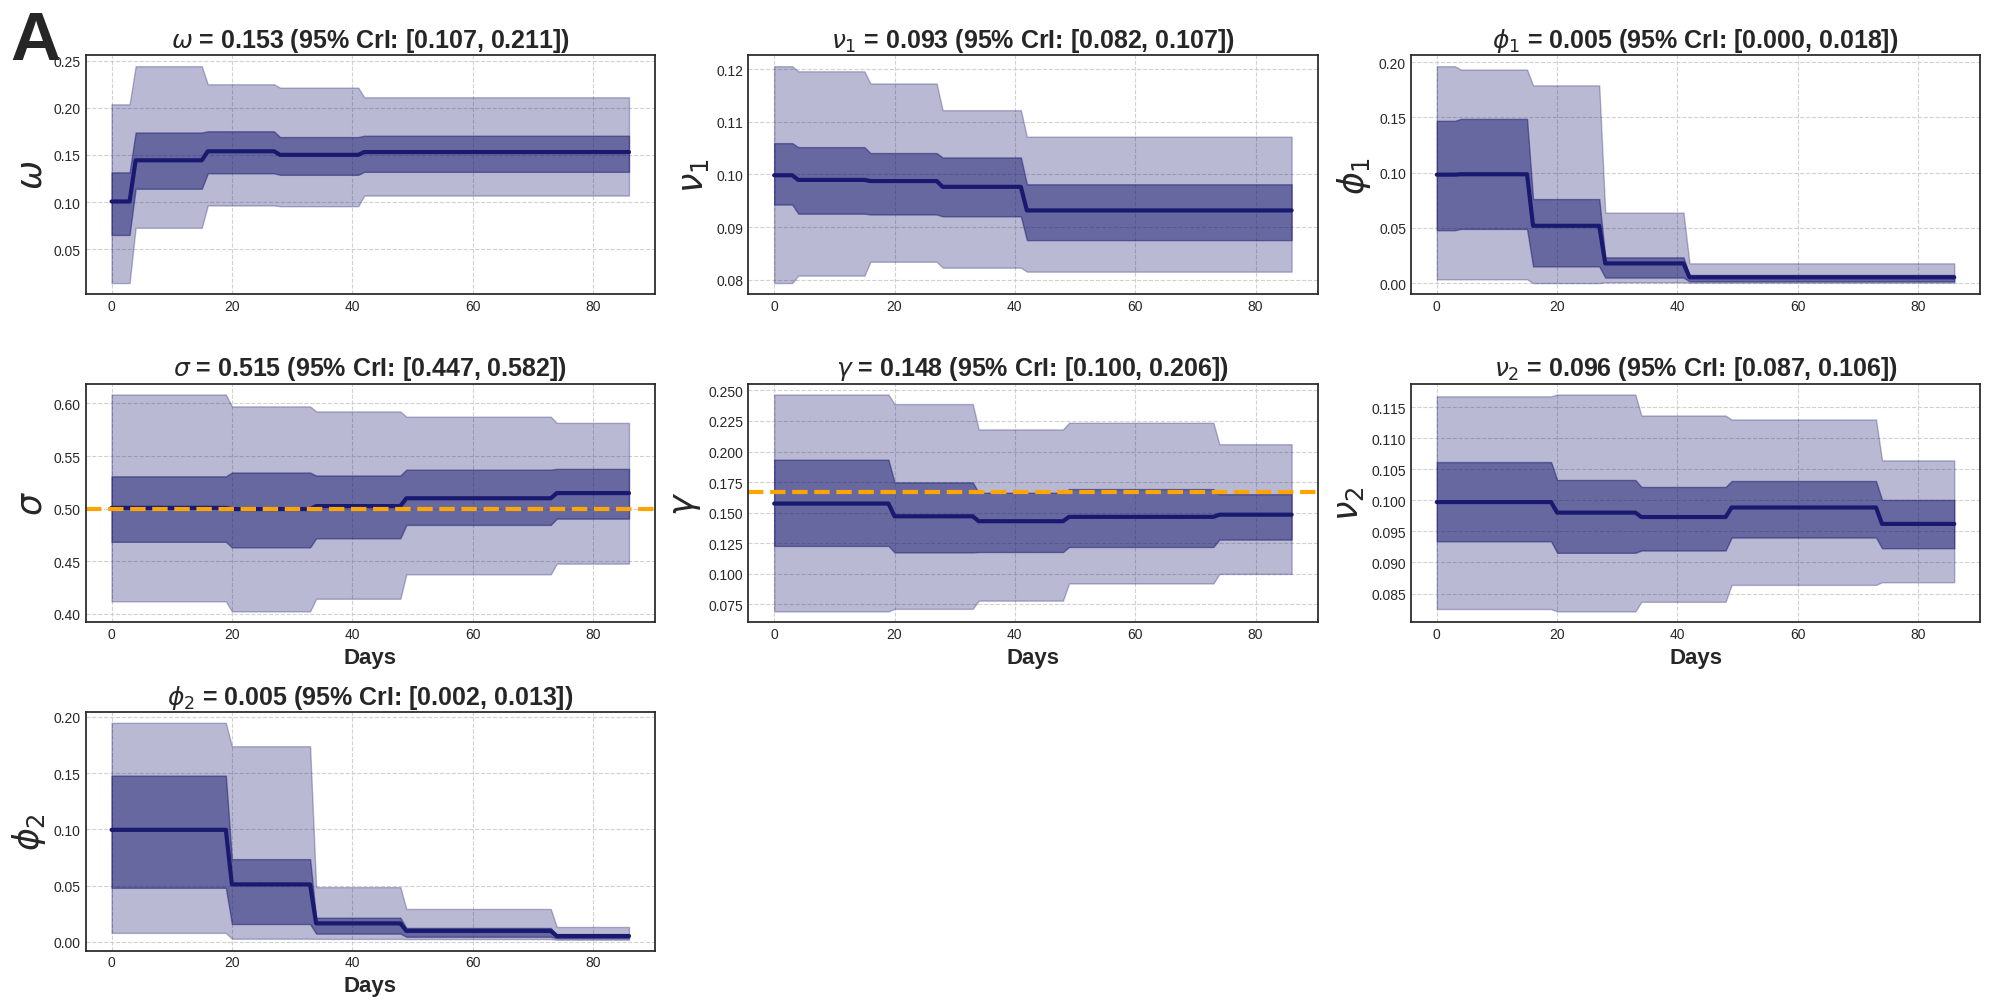

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# Separation point
# Separation point
plt.style.use('seaborn-v0_8-white')
separation_point = simulated_data['time'].iloc[-1] - fday

# Evolution of the model weights
w_dthp = smc2_results['weight_dthp']  
w_sir = smc2_results['weight_sir']

# Plotting model weights
fig, ax = plt.subplots(figsize=(11, 4))  
ax.plot(w_dthp, label='Weight DTHP', color='orange', linewidth=2, alpha=0.8)
ax.plot(w_sir, label='Weight SEIR', color='dodgerblue', linewidth=2, alpha=0.8)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Days', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Model weights', fontsize=18, fontweight='bold', labelpad=10)
ax.axvline(x=separation_point, color='black', linestyle='--', linewidth=2)
ax.set_title('Scenario A', fontsize=18, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, facecolor='white')
fig.tight_layout()
plt.show()

# Extract SIR and DTHP trajectories
trajParticles_state_sir = smc2_results['traj_state_sir']
matrix_dict_state_sir = trace_smc(trajParticles_state_sir)
trajParticles_theta_sir = smc2_results['traj_theta_sir']
matrix_dict_theta_sir = trace_smc(trajParticles_theta_sir)
gamma = np.mean(matrix_dict_theta_sir['gamma'][:, -1])
matrix_dict_state_sir['Rt'] = matrix_dict_state_sir['B'] / gamma

trajParticles_state_dthp = smc2_results['traj_state_dthp']
matrix_dict_state_dthp = trace_smc(trajParticles_state_dthp)
trajParticles_theta_dthp = smc2_results['traj_theta_dthp']
matrix_dict_theta_dthp = trace_smc(trajParticles_theta_dthp)

# Model average trajectories
matrix_dict_state_avg = compute_model_average(matrix_dict_state_dthp, matrix_dict_state_sir, w_dthp, w_sir)

# Plot Incidence and Rt
fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)
window = 1
forecast_start = separation_point
forecast_end = simulated_data['time'].iloc[-1]

# --- Add hatched forecast region ---
for ax in axs:
    ax.axvspan(
        forecast_start,
        forecast_end,
        facecolor='lightgray',
        edgecolor='gray',
        alpha=0.25,
        linewidth=0.0,
        zorder=1
    )

# --- Incidence Plot ---
for label, matrix, color in zip(
    ['DTHP', 'SIR', 'MA'],
    [matrix_dict_state_dthp['NI'], matrix_dict_state_sir['NI'], matrix_dict_state_avg['NI']],
    ['orange', 'dodgerblue', 'green']
):
    plot_smc(matrix, ax=axs[0], separation_point=separation_point, window=window, color=color, label=label)

axs[0].scatter(simulated_data['time'], 
               simulated_data['obs'].rolling(window=window, min_periods=1).mean(), 
               facecolor='brown', edgecolor='salmon', marker='*', s=60, label='Observed Data', zorder=2)
# axs[0].scatter(simulated_data['time'][days:], 
#                simulated_data['obs'][days:].rolling(window=window, min_periods=1).mean(), 
#                facecolor='orange', edgecolor='salmon', s=20, label='Observed Data (Forecast)', zorder=2)
axs[0].axvline(x=separation_point, color='black', linestyle='--', linewidth=2)
axs[0].set_ylabel("Incidence", fontsize=16, fontweight='bold')
# axs[0].set_title("Incidence Over Time", fontsize=18, fontweight='bold')
# axs[0].set_ylim([0,800])
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=14)

# --- Rt Plot ---
for label, matrix, color in zip(
    ['DTHP', 'SIR', 'MA'],
    [matrix_dict_state_dthp['Rt'], matrix_dict_state_sir['Rt'], matrix_dict_state_avg['Rt']],
    ['orange', 'dodgerblue', 'green']
):
    plot_smc(matrix, ax=axs[1], separation_point=separation_point, window=window, color=color, label=label)

axs[1].plot(simulated_data['time'], 
            simulated_data['Rt'].rolling(window=window, min_periods=1).mean(), 
            color='brown', lw=3, label='True $R_t$', zorder=3)
axs[1].axhline(y=1, color='k', linestyle='--', linewidth=2)
axs[1].set_ylabel(r"Reproduction number $R_t$", fontsize=16, fontweight='bold')
axs[1].set_xlabel("Days", fontsize=16, fontweight='bold')
axs[1].legend(loc='best', fontsize=12)
axs[1].set_ylim([0,6.3])
axs[1].tick_params(axis='both', which='major', labelsize=14)

# Final grid/styling
for ax in axs.flat:
    ax.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.show()

# --- Parameter Trajectories ---

L1 = [r'$\omega$', r'$\nu_{1}$', r'$\phi_1$']
L2 = [r'$\sigma$', r'$\gamma$', r'$\nu_{2}$', r'$\phi_2$']
n_plots = len(L1) + len(L2)
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

# Plot DTHP parameters
for i, (state, matrix) in enumerate(matrix_dict_theta_dthp.items()):
    ax = axes[i]
    plot_smc(matrix, ax=ax, show_50ci=True)
    ci_025 = np.percentile(matrix[:, -1], 2.5)
    ci_975 = np.percentile(matrix[:, -1], 97.5)
    median_estimate = np.mean(matrix[:, -1])
    ax.set_title(f'{L1[i]} = {median_estimate:.3f} (95% CrI: [{ci_025:.3f}, {ci_975:.3f}])', 
                 fontsize=18, fontweight='bold')
    ax.set_ylabel(L1[i], fontsize=25, fontweight='bold')

# Plot SIR parameters
for i, (state, matrix) in enumerate(matrix_dict_theta_sir.items()):
    ax = axes[i + len(L1)]
    plot_smc(matrix, ax=ax, show_50ci=True)
    ci_025 = np.percentile(matrix[:, -1], 2.5)
    ci_975 = np.percentile(matrix[:, -1], 97.5)
    median_estimate = np.mean(matrix[:, -1])
    ax.set_title(f'{L2[i]} = {median_estimate:.3f} (95% CrI: [{ci_025:.3f}, {ci_975:.3f}])', 
                 fontsize=18, fontweight='bold')
    if i <= 1:
        ax.axhline(true_theta[i], color='orange', linestyle='--', linewidth=3, label='True Value')
    ax.set_xlabel('Days', fontsize=16, fontweight='bold')
    ax.set_ylabel(L2[i], fontsize=25, fontweight='bold')

# Hide any unused subplots
for j in range(n_plots, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.02, 0.97, 'A', fontsize=50, fontweight='bold', ha='center', va='center')
for ax in axes[:n_plots]:
    ax.grid(True, linestyle='--', alpha=0.9)

plt.tight_layout()
plt.show()


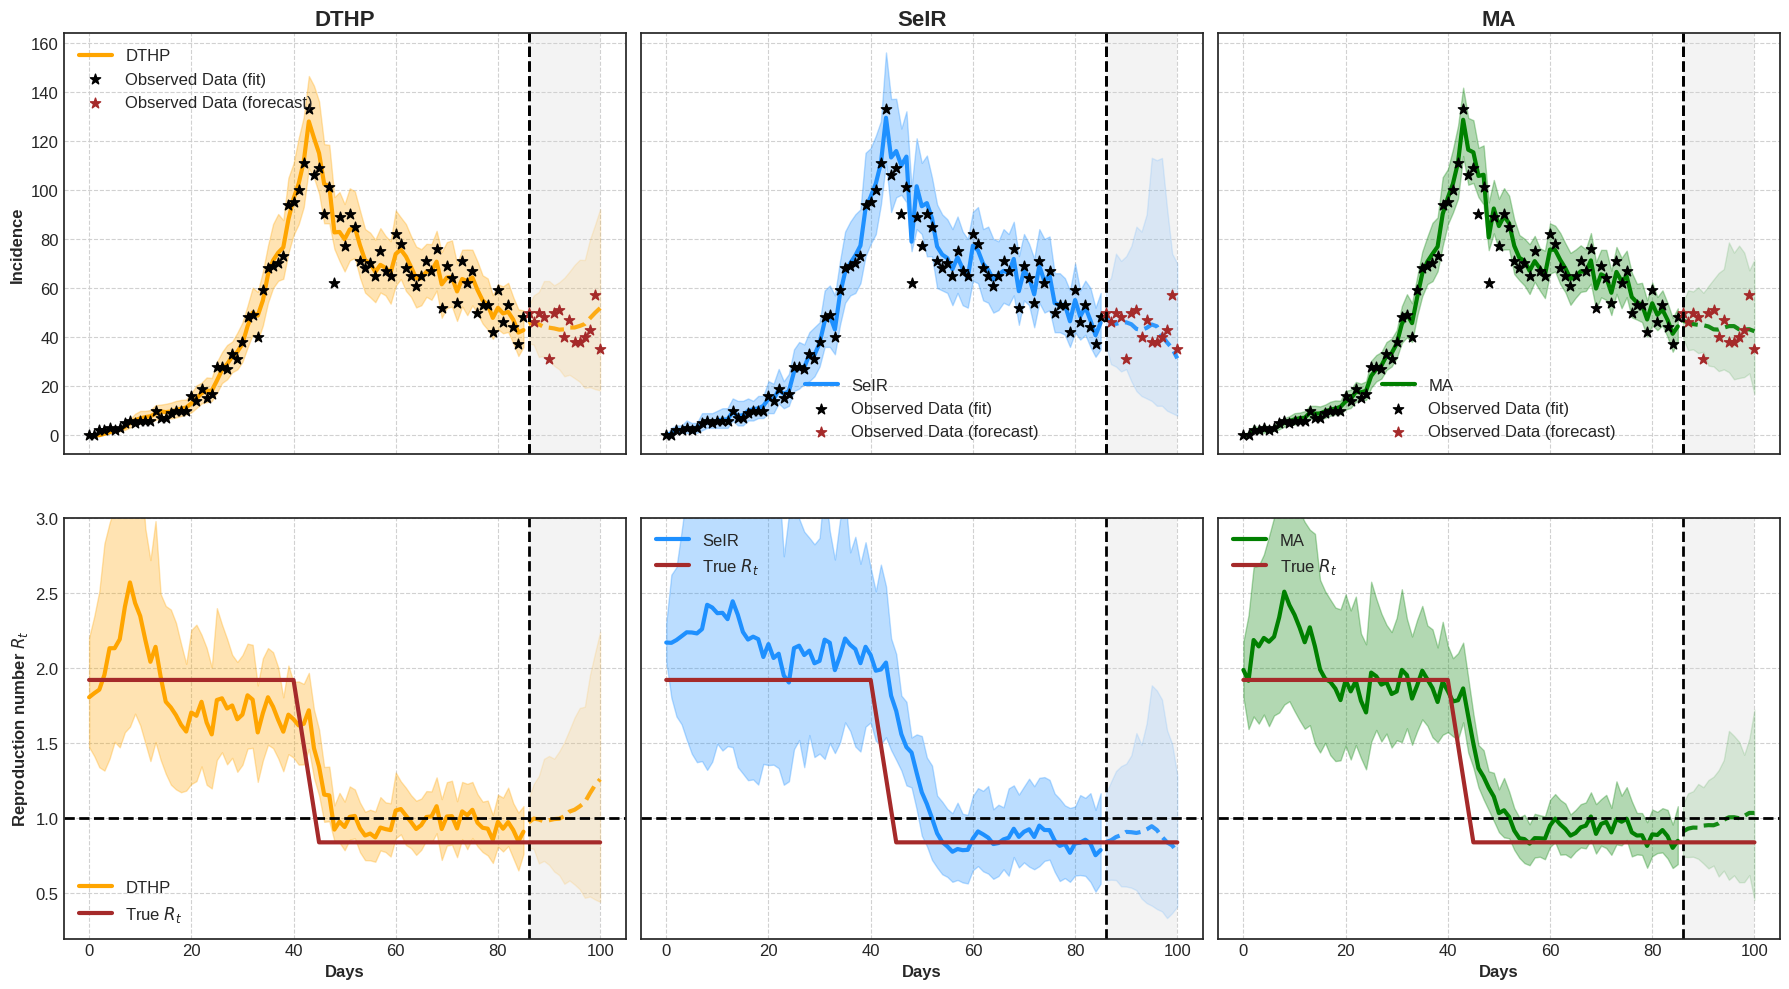

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey='row')  # Share y-axis per row

# --- Add hatched forecast region to all axes ---
for ax in axs.flat:
    ax.axvspan(
        forecast_start,
        forecast_end,
        facecolor='lightgray',
        edgecolor='gray',
        alpha=0.25,
        linewidth=0.0,
        zorder=1
    )

# --- Labels and colors for the models ---
models = ['DTHP', 'SIR', 'MA']
colors = ['orange', 'dodgerblue', 'green']
matrices = [
    (matrix_dict_state_dthp, 'DTHP'),
    (matrix_dict_state_sir, 'SeIR'),
    (matrix_dict_state_avg, 'MA')
]

# Rolling average of observed data
rolling_obs = simulated_data['obs'].rolling(window=window, min_periods=1).mean()
time = simulated_data['time']
before_sep = time < separation_point
after_sep = time >= separation_point

# --- Plotting for each model: incidence and Rt ---
for i, (matrix_dict, label) in enumerate(matrices):
    # Incidence subplot (row 0)
    ax_inc = axs[0, i]
    plot_smc(matrix_dict['NI'], ax=ax_inc, separation_point=separation_point, window=window, color=colors[i], label=label)

    # Plot observed data before and after separation
    ax_inc.scatter(time[before_sep],
                   rolling_obs[before_sep],
                   facecolor='black', marker='*', s=60, label='Observed Data (fit)', zorder=2)

    ax_inc.scatter(time[after_sep],
                   rolling_obs[after_sep],
                   facecolor='brown', marker='*', s=60, label='Observed Data (forecast)', zorder=2)

    ax_inc.axvline(x=separation_point, color='black', linestyle='--', linewidth=2)
    ax_inc.set_title(f"{label}", fontsize=16, fontweight='bold')
    if i == 0:
        ax_inc.set_ylabel("Incidence", fontsize=12, fontweight='bold')
    else:
        ax_inc.set_ylabel("")
        ax_inc.tick_params(labelleft=False)
    ax_inc.legend(fontsize=12)
    ax_inc.tick_params(axis='both', which='major', labelsize=12)

    # Rt subplot (row 1)
    ax_rt = axs[1, i]
    plot_smc(matrix_dict['Rt'], ax=ax_rt, separation_point=separation_point, window=window, color=colors[i], label=label)

    ax_rt.plot(simulated_data['time'],
               simulated_data['Rt'].rolling(window=window, min_periods=1).mean(),
               color='brown', lw=3, label='True $R_t$', zorder=3)

    ax_rt.axhline(y=1, color='k', linestyle='--', linewidth=2)
    ax_rt.set_ylim([0.2,3])
    if i == 0:
        ax_rt.set_ylabel(r"Reproduction number $R_t$", fontsize=12, fontweight='bold')
    else:
        ax_rt.set_ylabel("")
        ax_rt.tick_params(labelleft=False)
    ax_rt.set_xlabel("Days", fontsize=12, fontweight='bold')
    ax_rt.legend(fontsize=12)
    ax_rt.tick_params(axis='both', which='major', labelsize=12)

# Final formatting
for ax in axs.flat:
    ax.grid(True, linestyle='--', alpha=0.9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)  # Reduce vertical space between rows
plt.show()


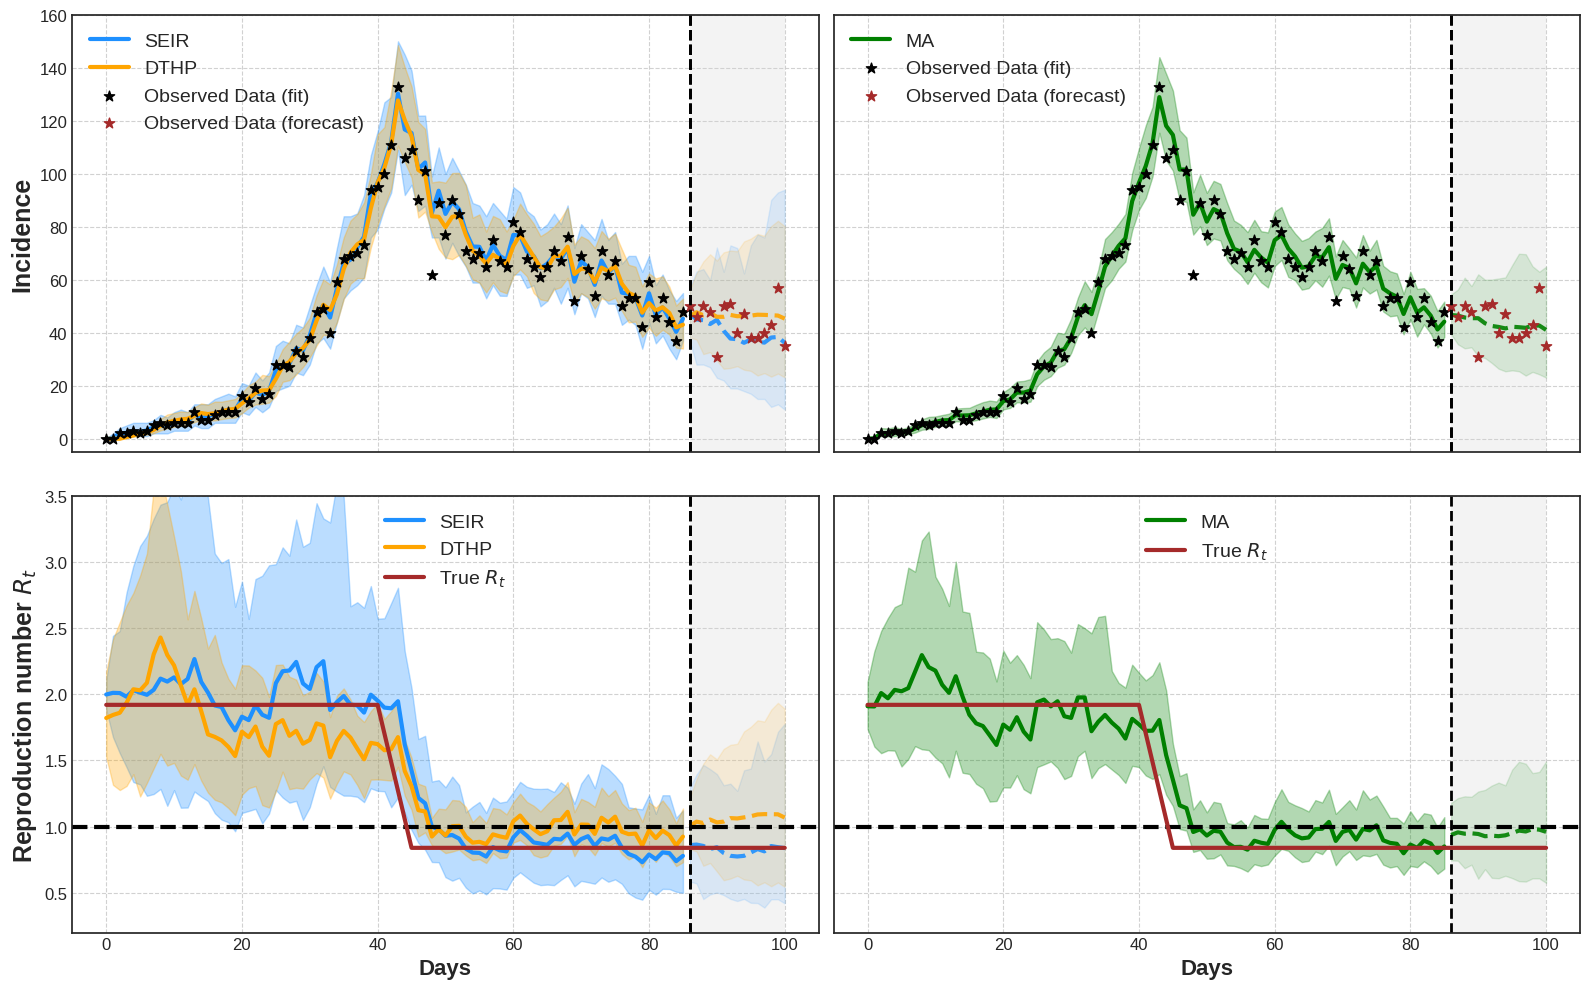

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey='row')  # 2 rows (NI, Rt), 2 cols (DTHP+SIR, MA)

# --- Add hatched forecast region to all axes ---
for ax in axs.flat:
    ax.axvspan(
        forecast_start,
        forecast_end,
        facecolor='lightgray',
        edgecolor='gray',
        alpha=0.25,
        linewidth=0.0,
        zorder=1
    )

models = ['SIR','DTHP',  'MA']
colors = [ 'dodgerblue', 'orange', 'green']
matrices = [
    (matrix_dict_state_sir, 'SEIR', colors[0]),
    (matrix_dict_state_dthp, 'DTHP', colors[1]),
    (matrix_dict_state_avg, 'MA', colors[2])
]

# Rolling average of observed data
rolling_obs = simulated_data['obs'].rolling(window=window, min_periods=1).mean()
time = simulated_data['time']
before_sep = time < separation_point
after_sep = time >= separation_point

# --- Incidence row ---
# Col 0: DTHP + SIR
for matrix_dict, label, color in matrices[:2]:
    ax_inc = axs[0, 0]
    plot_smc(matrix_dict['NI'], ax=ax_inc, separation_point=separation_point, window=window, color=color, label=label)

ax_inc.scatter(time[before_sep], rolling_obs[before_sep], facecolor='black', marker='*', s=60, label='Observed Data (fit)', zorder=2)
ax_inc.scatter(time[after_sep], rolling_obs[after_sep], facecolor='brown', marker='*', s=60, label='Observed Data (forecast)', zorder=2)
ax_inc.axvline(x=separation_point, color='black', linestyle='--', linewidth=2)
# ax_inc.set_title("Incidence: DTHP + SIR", fontsize=16, fontweight='bold')
ax_inc.set_ylabel("Incidence", fontsize=18, fontweight='bold')
ax_inc.legend(fontsize=14)
ax_inc.set_ylim([-5,160])
ax_inc.tick_params(axis='both', which='major', labelsize=12)

# Col 1: MA
ma_dict, ma_label, ma_color = matrices[2]
ax_inc_ma = axs[0, 1]
plot_smc(ma_dict['NI'], ax=ax_inc_ma, separation_point=separation_point, window=window, color=ma_color, label=ma_label)
ax_inc_ma.scatter(time[before_sep], rolling_obs[before_sep], facecolor='black', marker='*', s=60, label='Observed Data (fit)', zorder=2)
ax_inc_ma.scatter(time[after_sep], rolling_obs[after_sep], facecolor='brown', marker='*', s=60, label='Observed Data (forecast)', zorder=2)
ax_inc_ma.axvline(x=separation_point, color='black', linestyle='--', linewidth=2)
# ax_inc_ma.set_title("Incidence: MA", fontsize=16, fontweight='bold')
ax_inc_ma.tick_params(axis='both', which='major', labelsize=12)
ax_inc_ma.legend(fontsize=14)

# --- Rt row ---
# Col 0: DTHP + SIR
for matrix_dict, label, color in matrices[:2]:
    ax_rt = axs[1, 0]
    plot_smc(matrix_dict['Rt'], ax=ax_rt, separation_point=separation_point, window=window, color=color, label=label)

ax_rt.plot(time, simulated_data['Rt'].rolling(window=window, min_periods=1).mean(),
           color='brown', lw=3, label='True $R_t$', zorder=3)
ax_rt.axhline(y=1, color='k', linestyle='--', linewidth=3)
# ax_rt.set_title(r"$R_t$: DTHP + SIR", fontsize=16, fontweight='bold')
ax_rt.set_ylabel(r"Reproduction number $R_t$", fontsize=18, fontweight='bold')
ax_rt.set_xlabel("Days", fontsize=16, fontweight='bold')
ax_rt.legend(fontsize=14, loc='upper center')
ax_rt.tick_params(axis='both', which='major', labelsize=12)

# Col 1: MA
ax_rt_ma = axs[1, 1]
plot_smc(ma_dict['Rt'], ax=ax_rt_ma, separation_point=separation_point, window=window, color=ma_color, label=ma_label)
ax_rt_ma.plot(time, simulated_data['Rt'].rolling(window=window, min_periods=1).mean(),
              color='brown', lw=3, label='True $R_t$', zorder=3)
ax_rt_ma.axhline(y=1, color='k', linestyle='--', linewidth=3)
# ax_rt_ma.set_title(r"$R_t$: MA", fontsize=16, fontweight='bold')
ax_rt_ma.set_xlabel("Days", fontsize=16, fontweight='bold')
ax_rt_ma.set_ylim([0.2, 3.5])
ax_rt_ma.tick_params(axis='both', which='major', labelsize=12)
ax_rt_ma.legend(fontsize=14, loc='upper center')

# Final formatting
for ax in axs.flat:
    ax.grid(True, linestyle='--', alpha=0.9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Simple CRPS function (Monte Carlo approx.)
def compute_crps(pred_matrix, true_vals):
    """Compute CRPS using sample approximation."""
    N_samples = pred_matrix.shape[0]
    crps_list = []
    for i in range(pred_matrix.shape[1]):  # Loop over time points
        preds = pred_matrix[:, i]
        true = true_vals[i]
        term1 = np.mean(np.abs(preds - true))
        term2 = 0.5 * np.mean(np.abs(preds[:, None] - preds[None, :]))
        crps = term1 - term2
        crps_list.append(crps)
    return np.mean(crps_list)  # Average over time points

def compute_metrics(true_vals, pred_matrix):
    pred_mean = pred_matrix.mean(axis=0)
    rmse = np.sqrt(mean_squared_error(true_vals, pred_mean))

    # 95% credible interval bounds
    ci_lower = np.percentile(pred_matrix, 2.5, axis=0)
    ci_upper = np.percentile(pred_matrix, 97.5, axis=0)

    # RMSE computed against the lower and upper CI bounds
    rmse_ci = (np.sqrt(mean_squared_error(true_vals, ci_lower)),
               np.sqrt(mean_squared_error(true_vals, ci_upper)))

    # Coverage calculation
    coverage = np.mean((true_vals >= ci_lower) & (true_vals <= ci_upper)) * 100

    # CRPS calculation
    crps = compute_crps(pred_matrix, true_vals)

    return rmse, rmse_ci, coverage, crps

def format_error_with_ci(mean, ci):
    return f"{mean:.3f} ({ci[0]:.3f}, {ci[1]:.3f})"

def create_summary_table(models_dict, simulated_data, separation_point, variable_name='NI'):
    results_in = []
    results_proj = []

    for model_name, matrix_dict in models_dict.items():
        matrix = matrix_dict[variable_name]
        time = simulated_data['time'].values
        true_vals = simulated_data['obs'].values if variable_name == 'NI' else simulated_data['Rt'].values

        in_mask = time < separation_point
        proj_mask = time >= separation_point

        # In-sample metrics
        rmse, rmse_ci, cov, crps = compute_metrics(true_vals[in_mask], matrix[:, in_mask])
        results_in.append([
            model_name,
            variable_name,
            format_error_with_ci(rmse, rmse_ci),
            round(cov, 3),
            round(crps, 3)
        ])

        # Projection metrics
        rmse, rmse_ci, cov, crps = compute_metrics(true_vals[proj_mask], matrix[:, proj_mask])
        results_proj.append([
            model_name,
            variable_name,
            format_error_with_ci(rmse, rmse_ci),
            round(cov, 3),
            round(crps, 3)
        ])

    columns = ['Model', 'Variable', 'RMSE (95% CI)', 'Coverage (%)', 'CRPS']
    df_in = pd.DataFrame(results_in, columns=columns)
    df_proj = pd.DataFrame(results_proj, columns=columns)

    return df_in, df_proj

# --- Define model results ---
models = {
    'DTHP': matrix_dict_state_dthp,
    'SIR': matrix_dict_state_sir,
    'MA': matrix_dict_state_avg
}

# --- Compute in-sample and projection tables ---
in_sample_NI, proj_NI = create_summary_table(models, simulated_data, separation_point, variable_name='NI')
in_sample_Rt, proj_Rt = create_summary_table(models, simulated_data, separation_point, variable_name='Rt')

# --- Combine and display ---
in_sample_combined = pd.concat([in_sample_NI, in_sample_Rt], ignore_index=True)
proj_combined = pd.concat([proj_NI, proj_Rt], ignore_index=True)

print("=== In-Sample Metrics ===")
display(in_sample_combined)

print("\n=== Projection Metrics ===")
display(proj_combined)


=== In-Sample Metrics ===


,Model,Variable,RMSE (95% CI),Coverage (%),CRPS
0,DTHP,NI,"4.749 (10.285, 13.026)",95.349,2.404
1,SIR,NI,"4.067 (10.887, 15.338)",98.837,2.012
2,MA,NI,"4.223 (7.646, 10.807)",96.512,1.963
3,DTHP,Rt,"0.219 (0.427, 0.526)",75.581,0.133
4,SIR,Rt,"0.180 (0.522, 0.958)",96.512,0.105
5,MA,Rt,"0.171 (0.354, 0.524)",93.023,0.093



=== Projection Metrics ===


,Model,Variable,RMSE (95% CI),Coverage (%),CRPS
0,DTHP,NI,"7.087 (17.657, 29.743)",100.000,4.179
1,SIR,NI,"8.236 (25.363, 31.991)",100.000,5.679
2,MA,NI,"6.685 (16.883, 20.288)",93.333,3.863
3,DTHP,Rt,"0.222 (0.220, 0.832)",100.000,0.119
4,SIR,Rt,"0.033 (0.377, 0.639)",100.000,0.066
5,MA,Rt,"0.112 (0.207, 0.508)",100.000,0.065


In [7]:
# n_run=10
# results = []  # List to store results of each run
# progress_bar = tqdm(total=n_run, desc="Multiple runs SMC2 Progress")
# for i in range(n_run):

#     # Execute the particle filter
#     M = BMA_SMC2(
#     model_sir=stochastic_sir_model,
#     model_dthp= dthp_model, 
#     initial_state_info_dthp=state_info_dthp , 
#     initial_theta_info_dthp=theta_info_dthp , 
#     initial_state_info_sir=state_info_sir , 
#     initial_theta_info_sir=theta_info_sir , 
#     observed_data=simulated_data[:days],
#     num_state_particles=200,
#     num_theta_particles=400,
#     observation_distribution=obs_dist_negative_binomial,
#     forecast_days=fday,
#     N=N_pop,
#     show_progress=False
#     )
        
#     # Store the result
#     results.append(M)
#     progress_bar.update(1)

# progress_bar.close()

In [8]:
# with open("Ens_SMC2_exp1_Metric.wpickle", "wb") as file:
#     pickle.dump(results, file)

# with open("Ens_SMC2_exp1_Metric.wpickle", "rb") as file:
#    results= pickle.load(file)

In [9]:
import numpy as np

def replace_outliers(matrix):
    # Calculate the IQR for each column
    q1 = np.percentile(matrix, 25, axis=0)
    q3 = np.percentile(matrix, 75, axis=0)
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Replace outliers with appropriate values
    for col in range(matrix.shape[1]):
        col_values = matrix[:, col]
        col_non_outliers = col_values[(col_values >= lower_bound[col]) & (col_values <= upper_bound[col])]
        max_non_outlier = np.mean(col_non_outliers)
        min_non_outlier = np.mean(col_non_outliers)
        
        # Replace outliers above the upper bound
        outliers_above = col_values[col_values > upper_bound[col]]
        if len(outliers_above) > 0:
            matrix[col_values > upper_bound[col], col] = max_non_outlier
        
        # Replace outliers below the lower bound
        outliers_below = col_values[col_values < lower_bound[col]]
        if len(outliers_below) > 0:
            matrix[col_values < lower_bound[col], col] = min_non_outlier
    
    return matrix

def compute_medians_and_weighted_average(results):
    all_sir_medians_NI = []
    all_sir_medians_Rt = []
    all_dthp_medians_NI = []
    all_dthp_medians_Rt = []
    weighted_medians_NI = []
    weighted_medians_Rt = []
    all_sir_weights = []
    all_dthp_weights = []
    
    for M in results:
        # Extract model weights
        w_dthp = M['weight_dthp']  # Convert to numpy array for easier manipulation
        w_sir = M['weight_sir']
        

        
        all_sir_weights.append(w_sir)
        all_dthp_weights.append(w_dthp)

        # sir Model
        trajParticles_sir = M['traj_state_sir']
        trajParticles_theta_sir = M['traj_theta_sir']
        
        matrix_dict_sir = trace_smc(trajParticles_sir)
        matrix_dict2 = trace_smc(trajParticles_theta_sir)
        
        matrix_dict_sir['Rt'] = matrix_dict_sir['B']/ np.mean(matrix_dict2['gamma'][:,-1])*matrix_dict_state_sir['S']/N_pop
        
        
        median_values_NI_sir = np.mean(replace_outliers(matrix_dict_sir['NI'] ), axis=0)
        median_values_Rt_sir = np.mean(replace_outliers(matrix_dict_sir['Rt'] ), axis=0)
        
        all_sir_medians_NI.append(median_values_NI_sir)
        all_sir_medians_Rt.append(median_values_Rt_sir)
        
        # DTHP Model
        trajParticles_dthp = M['traj_state_dthp']
        matrix_dict_dthp = trace_smc(trajParticles_dthp)
        
        median_values_NI_dthp = np.mean(replace_outliers(matrix_dict_dthp['NI'] ), axis=0)
        median_values_Rt_dthp = np.mean(replace_outliers(matrix_dict_dthp['Rt'] ), axis=0)
        
        all_dthp_medians_NI.append(median_values_NI_dthp)
        all_dthp_medians_Rt.append(median_values_Rt_dthp)


        matrix_dict_avg = compute_model_average(matrix_dict_dthp, matrix_dict_sir, w_dthp,  w_sir)


        # Weighted average median values
        weighted_median_NI = np.mean(replace_outliers(matrix_dict_avg['NI'] ), axis=0)
        weighted_median_Rt = np.mean(replace_outliers(matrix_dict_avg['Rt'] ), axis=0)
        
        weighted_medians_NI.append(weighted_median_NI)
        weighted_medians_Rt.append(weighted_median_Rt)
    
    return {
        'sir_medians_NI': all_sir_medians_NI,
        'sir_medians_Rt': all_sir_medians_Rt,
        'dthp_medians_NI': all_dthp_medians_NI,
        'dthp_medians_Rt': all_dthp_medians_Rt,
        'weighted_medians_NI': weighted_medians_NI,
        'weighted_medians_Rt': weighted_medians_Rt,
        'sir_weights': all_sir_weights,
        'dthp_weights': all_dthp_weights
    }

# Example usage:
medians_results = compute_medians_and_weighted_average(results)


NameError: name 'results' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and WMAPE
def calculate_error_metrics(true_NI, true_Rt, medians_results, days):
    error_metrics = []

    # Number of runs
    n_run = len(medians_results['sir_medians_NI'])

    for i in range(n_run):
        # Extract sir, DTHP, and weighted median values for NI and Rt
        sir_NI = medians_results['sir_medians_NI'][i]
        dthp_NI = medians_results['dthp_medians_NI'][i]
        weighted_NI = medians_results['weighted_medians_NI'][i]

        sir_Rt = medians_results['sir_medians_Rt'][i]
        dthp_Rt = medians_results['dthp_medians_Rt'][i]
        weighted_Rt = medians_results['weighted_medians_Rt'][i]

        # Compute RMSE for the [:days] period
        sir_rmse_NI = np.sqrt(mean_squared_error(true_NI[:days], sir_NI[:days]))
        dthp_rmse_NI = np.sqrt(mean_squared_error(true_NI[:days], dthp_NI[:days]))
        weighted_rmse_NI = np.sqrt(mean_squared_error(true_NI[:days], weighted_NI[:days]))

        sir_rmse_Rt = np.sqrt(mean_squared_error(true_Rt[:days], sir_Rt[:days]))
        dthp_rmse_Rt = np.sqrt(mean_squared_error(true_Rt[:days], dthp_Rt[:days]))
        weighted_rmse_Rt = np.sqrt(mean_squared_error(true_Rt[:days], weighted_Rt[:days]))

        # Compute WMAPE for the [days:] period
        sir_wmape_NI = 100 * np.sum(np.abs(sir_NI[days:] - true_NI[days:])) / np.sum(np.abs(true_NI[days:]))
        dthp_wmape_NI = 100 * np.sum(np.abs(dthp_NI[days:] - true_NI[days:])) / np.sum(np.abs(true_NI[days:]))
        weighted_wmape_NI = 100 * np.sum(np.abs(weighted_NI[days:] - true_NI[days:])) / np.sum(np.abs(true_NI[days:]))

        sir_wmape_Rt = 100 * np.sum(np.abs(sir_Rt[days:] - true_Rt[days:])) / np.sum(np.abs(true_Rt[days:]))
        dthp_wmape_Rt = 100 * np.sum(np.abs(dthp_Rt[days:] - true_Rt[days:])) / np.sum(np.abs(true_Rt[days:]))
        weighted_wmape_Rt = 100 * np.sum(np.abs(weighted_Rt[days:] - true_Rt[days:])) / np.sum(np.abs(true_Rt[days:]))

        # Store the results in a dictionary
        error_metrics.append({
            'Run': i + 1,
            'Model': 'SIR',
            'Metric': 'NI',
            'RMSE': sir_rmse_NI,
            'WMAPE': sir_wmape_NI
        })
        error_metrics.append({
            'Run': i + 1,
            'Model': 'DTHP',
            'Metric': 'NI',
            'RMSE': dthp_rmse_NI,
            'WMAPE': dthp_wmape_NI
        })
        error_metrics.append({
            'Run': i + 1,
            'Model': 'MA',
            'Metric': 'NI',
            'RMSE': weighted_rmse_NI,
            'WMAPE': weighted_wmape_NI
        })
        error_metrics.append({
            'Run': i + 1,
            'Model': 'SIR',
            'Metric': 'Rt',
            'RMSE': sir_rmse_Rt,
            'WMAPE': sir_wmape_Rt
        })
        error_metrics.append({
            'Run': i + 1,
            'Model': 'DTHP',
            'Metric': 'Rt',
            'RMSE': dthp_rmse_Rt,
            'WMAPE': dthp_wmape_Rt
        })
        error_metrics.append({
            'Run': i + 1,
            'Model': 'MA',
            'Metric': 'Rt',
            'RMSE': weighted_rmse_Rt,
            'WMAPE': weighted_wmape_Rt
        })

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(error_metrics)




In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(df_error_metrics):
    # Separate metrics for NI and Rt
    ni_metrics = df_error_metrics[df_error_metrics['Metric'] == 'NI']
    rt_metrics = df_error_metrics[df_error_metrics['Metric'] == 'Rt']

    # Define the colors for each model
    model_colors = {'SIR': 'dodgerblue', 'DTHP': 'orange', 'MA': 'green'}
    model_order = ['DTHP', 'SIR', 'MA']

    # ------------------- Plot RMSE -------------------
    fig_rmse, axs_rmse = plt.subplots(2, 1, figsize=(5, 8), constrained_layout=False)

    # Plot Incidence RMSE
    box = axs_rmse[0].boxplot(
        [ni_metrics[ni_metrics['Model'] == model]['RMSE'] for model in model_order],
        patch_artist=True,
        boxprops=dict(facecolor='none', color='black', lw=2),
        capprops=dict(color='black', lw=2),
        whiskerprops=dict(color='black', lw=2),
        flierprops=dict(markerfacecolor='black', marker='o', markersize=5),
        medianprops=dict(color='black', linewidth=2)
    )
    for i, model in enumerate(model_order):
        box['boxes'][i].set_facecolor(model_colors[model])
    axs_rmse[0].set_title('Incidence', fontsize=16, fontweight='bold')
    axs_rmse[0].set_ylabel('RMSE', fontsize=16, fontweight='bold')
    axs_rmse[0].set_xticklabels(model_order)
    axs_rmse[0].tick_params(axis='both', which='major', labelsize=14)

    # Plot Reproduction number RMSE
    box = axs_rmse[1].boxplot(
        [rt_metrics[rt_metrics['Model'] == model]['RMSE'] for model in model_order],
        patch_artist=True,
        boxprops=dict(facecolor='none', color='black', lw=2),
        capprops=dict(color='black', lw=2),
        whiskerprops=dict(color='black', lw=2),
        flierprops=dict(markerfacecolor='black', marker='o', markersize=5),
        medianprops=dict(color='black', linewidth=2)
    )
    for i, model in enumerate(model_order):
        box['boxes'][i].set_facecolor(model_colors[model])
    axs_rmse[1].set_title('Reproduction number', fontsize=16, fontweight='bold')
    axs_rmse[1].set_ylabel('RMSE', fontsize=16, fontweight='bold')
    axs_rmse[1].set_xticklabels(model_order)
    axs_rmse[1].tick_params(axis='both', which='major', labelsize=14)

    # Styling
    for ax in axs_rmse.flat:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_facecolor('whitesmoke')
    fig_rmse.text(0.5, 0.95, 'A', fontsize=30, fontweight='bold', ha='center', va='center')
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    # ------------------- Plot wMAPE -------------------
    fig_wmape, axs_wmape = plt.subplots(2, 1, figsize=(5, 8), constrained_layout=False)

    # Plot Incidence wMAPE
    box = axs_wmape[0].boxplot(
        [ni_metrics[ni_metrics['Model'] == model]['WMAPE'] for model in model_order],
        patch_artist=True,
        boxprops=dict(facecolor='none', color='black', lw=2),
        capprops=dict(color='black', lw=2),
        whiskerprops=dict(color='black', lw=2),
        flierprops=dict(markerfacecolor='black', marker='o', markersize=5),
        medianprops=dict(color='black', linewidth=2)
    )
    for i, model in enumerate(model_order):
        box['boxes'][i].set_facecolor(model_colors[model])
    axs_wmape[0].set_title('Incidence', fontsize=16, fontweight='bold')
    axs_wmape[0].set_ylabel('wMAPE (%)', fontsize=16, fontweight='bold')
    axs_wmape[0].set_xticklabels(model_order)
    axs_wmape[0].tick_params(axis='both', which='major', labelsize=14)

    # Plot Reproduction number wMAPE
    box = axs_wmape[1].boxplot(
        [rt_metrics[rt_metrics['Model'] == model]['WMAPE'] for model in model_order],
        patch_artist=True,
        boxprops=dict(facecolor='none', color='black', lw=2),
        capprops=dict(color='black', lw=2),
        whiskerprops=dict(color='black', lw=2),
        flierprops=dict(markerfacecolor='black', marker='o', markersize=5),
        medianprops=dict(color='black', linewidth=2)
    )
    for i, model in enumerate(model_order):
        box['boxes'][i].set_facecolor(model_colors[model])
    axs_wmape[1].set_title('Reproduction number', fontsize=16, fontweight='bold')
    axs_wmape[1].set_ylabel('wMAPE (%)', fontsize=16, fontweight='bold')
    axs_wmape[1].set_xticklabels(model_order)
    axs_wmape[1].tick_params(axis='both', which='major', labelsize=14)

    # Styling
    for ax in axs_wmape.flat:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_facecolor('whitesmoke')
    fig_wmape.text(0.5, 0.95, 'A', fontsize=30, fontweight='bold', ha='center', va='center')
    plt.subplots_adjust(hspace=0.3)
    plt.show()

# Example data
true_NI = simulated_data['obs']  # Observed Incidence (NI)
true_Rt = simulated_data['Rt']  
df_error_metrics = calculate_error_metrics(true_NI, true_Rt, medians_results, days)
plot_metrics(df_error_metrics)


In [ ]:
import pandas as pd

# Assuming df_error_metrics is already defined

# Define the custom order for 'Metric' column
metric_order = {'NI': 0, 'Rt': 1}

# Calculate mean errors across all runs
mean_errors = df_error_metrics.groupby(['Model', 'Metric']).agg({
    'RMSE': 'mean',
    'WMAPE': 'mean',
}).reset_index()

# Create a new column to facilitate sorting
mean_errors['Metric_order'] = mean_errors['Metric'].map(metric_order)

# Sort the DataFrame by the custom order and then by 'Model'
mean_errors_sorted = mean_errors.sort_values(by=['Metric_order', 'Model']).drop(columns='Metric_order')

# Create the RMSE table
rmse_table = mean_errors_sorted[['Model', 'Metric', 'RMSE']].pivot(index='Model', columns='Metric', values='RMSE')

# Create the WMAPE table
wmape_table = mean_errors_sorted[['Model', 'Metric', 'WMAPE']].pivot(index='Model', columns='Metric', values='WMAPE')

# Print the tables
print("RMSE Table:")
print(rmse_table)

print("\nWMAPE Table:")
print(wmape_table)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_weights_from_results(medians_results):
    """
    Plots the weights for sir and DTHP models over time.
    
    Parameters:
    - medians_results: dict
        A dictionary containing the keys 'sir_weights' and 'dthp_weights', each of which
        is a list of lists, where each inner list corresponds to a single run's weights over time.
    - separation_point: int or None
        An optional vertical line to indicate a specific time point on the plot.
    """
    # Extract sir and DTHP weights
    sir_weights_all = medians_results['sir_weights']
    dthp_weights_all = medians_results['dthp_weights']

    # Create figure
    fig, ax = plt.subplots(figsize=(9, 4))  # Create a figure with a larger size for better clarity

    # Plot each run
    for run_idx, (sir_weights, dthp_weights) in enumerate(zip(sir_weights_all, dthp_weights_all)):
        time_points = list(range(len(sir_weights)))  # assuming weights are indexed by time
        
        # Plot DTHP weights
        ax.plot(time_points, dthp_weights, color='orange', alpha=0.7, lw=2, label='DTHP Weight' if run_idx == 0 else "")
        
        # Plot sir weights
        ax.plot(time_points, sir_weights, color='dodgerblue', alpha=0.7, lw=2, label='SIR Weight' if run_idx == 0 else "")
    
    # Set titles and labels
    # ax.set_title('Scenario A', fontweight='bold', fontsize=15)
    # ax.set_xlabel('Days', fontsize=18, fontweight='bold', labelpad=10)
    ax.set_ylabel('Model Weights', fontsize=18, fontweight='bold', labelpad=10)
    
    # Add grid and background
    ax.grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines
    ax.set_facecolor('whitesmoke')  # Add light background color to the plot area

    # Add a vertical line if separation_point is provideddays
    if separation_point is not None:
        ax.axvline(x=separation_point, color='black', linestyle='--', linewidth=2)

    # Add legend
    ax.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, facecolor='white')
95%
    # Add annotation to the top of the figure
    fig.text(-0.02, 0.5, 'A', fontsize=30, fontweight='bold', ha='center', va='center')

    # Adjust layout for better appearance
    fig.tight_layout()

    # Display the plot
    plt.show()

plot_weights_from_results(medians_results)


In [ ]:
import numpy as np
B=np.arange(0,2,1)
A=np.array([0,1,2])
for i in range(1, len(B)):
    A+=i
print(A[-1],i)